<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Learning a SDE with Pyro MCMC
</div>

(Ref : ch11. from Sarkka and Solin "Applied Stochastic Differential Equations")

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
import torchsde

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS

In [21]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    # if using a GPU (CUDA) and num_chains > 1
    torch.multiprocessing.set_start_method('spawn', force=True)
else:
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)
print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
0 : Create sample path from a Stochastic Differential Equation
</div>

General formulation : 

\begin{align}
dX_t &= F(X_t,t) dt + L(X_t,t) dB_t \\
X_0 &= x_0
\end{align}

Here :

\begin{align}
X_t &\in \mathbb{R} \\
F &: \mathbb{R} \times \mathbb{R}^{+} \longrightarrow \mathbb{R} \\
L &: \mathbb{R} \times \mathbb{R}^{+} \longrightarrow \mathbb{R}^{+} \\
dB_t &\sim \mathcal{N}(0,dt)
\end{align}

### Ground Truth SDE

In [23]:
LAMBDA_OU = 5.0
SIGMA_OU = 0.1

In [24]:
class SDE():
    """
    Generic class of a SDE
    """
    def __init__(self, drift=None, diffusion=None, name=None):
        if name is None:
            self.name = "Default Ornstein Uhlenbeck (lambda -5.0, diffusion 1.0)"
        else:
            self.name = name
        if drift is None:
            self.drift = lambda t,x : -LAMBDA_OU * x
        else:
            self.drift = drift
        if diffusion is None:
            self.diffusion = lambda t,x : SIGMA_OU
        else:
            self.diffusion = diffusion

    def drift(self, t, x):
        return self.drift(t,x)

    def diffusion(self, t, x):
        return self.diffusion(t,x)

    def __repr__(self) -> str:
        msg = f"""
        SDE object, name : {self.name}
        \tdrift function : {self.drift}
        \tdiffusion function : {self.diffusion}
        """
        return msg

    def step(self,t,x,dt,dBt=None):
        """
        One step of the SDE, from (t,x) to (t+dt, x_{t+dt}). 
        Return dX_t
        If the Gaussian increment is not given, sample one.
        """
        if dBt is None:
            eps = torch.randn()
            dBt = torch.sqrt(dt) * eps
        return self.drift(t,x) * dt + self.diffusion(t,x) * dBt
    
sde = SDE()
print(sde)


        SDE object, name : Default Ornstein Uhlenbeck (lambda -5.0, diffusion 1.0)
        	drift function : <function SDE.__init__.<locals>.<lambda> at 0x7fa089bab920>
        	diffusion function : <function SDE.__init__.<locals>.<lambda> at 0x7fa089bcc720>
        


In [25]:
# simulate path
N_POINTS = 250 # number of points in each y_start = 0.0  # initial condition
N_PATHS = 1 # number of paths to sample - usually 1, not sure the MCMC is relevant for > 1

t_start = 0.0
t_end = 10.0
ts = torch.linspace(t_start, t_end, N_POINTS).to(device)  # time stamps where we want the solution, between 0 and 1
# print(f"Time stamps shape : {ts.shape}")  # shape (N_POINTS,)

# sanity check on the time scale
dt = (t_end - t_start) / N_POINTS

# sampling Brownian motions - we will reuse them for the reconstruction
bm = torch.randn((N_POINTS-1, N_PATHS))

y_start = 0.0  # initial condition
ys = torch.full((N_POINTS, N_PATHS), fill_value=y_start)
ys_2 = torch.full((N_POINTS, N_PATHS), fill_value=y_start)

for i in range(1,N_POINTS):
    ys_2[i,:] = ys_2[i-1,:] + sde.step(ts[i-1], ys_2[i-1], dt, dBt=bm[i-1])  # with SDE
    ys[i,:] = ys[i-1,:] + -LAMBDA_OU * ys[i-1,:] * dt + SIGMA_OU * bm[i-1]  # hand made
    
ys = ys.unsqueeze(-1)
ys_2 = ys_2.unsqueeze(-1)
print(f"Data shape : {ys.size()}")

Data shape : torch.Size([250, 1, 1])


/home/benjamin/anaconda3/envs/torchy/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


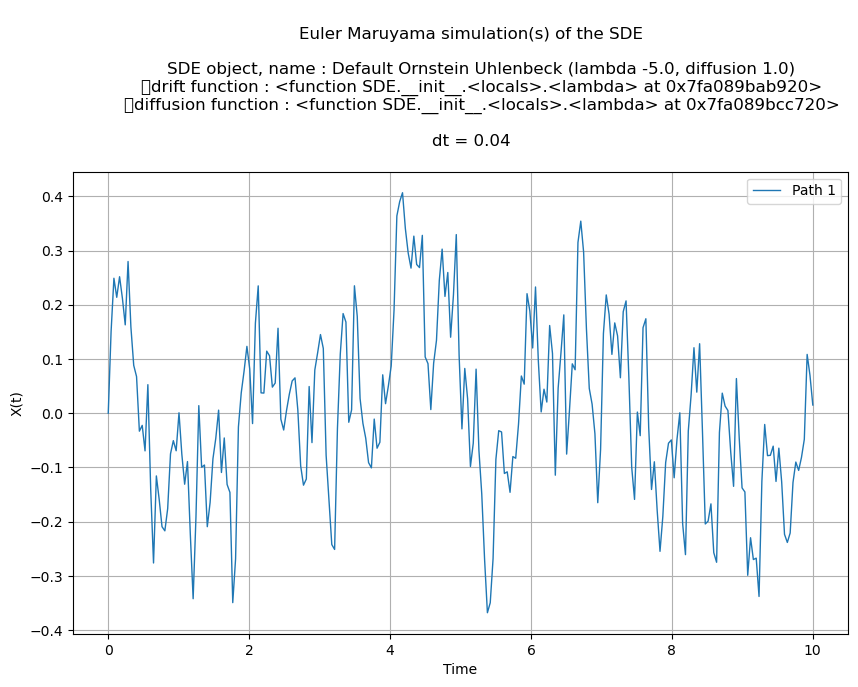

In [26]:
def plot_sde_samples(ts, ys, title=None):
    """
    Utility functions to plot the sampled SDE solutions
    """
    fig, ax = plt.subplots(figsize=(10,6))
    n_points = ts.size()[0]
    n_paths = ys.size()[1]
    
    for i, y in enumerate(ys.permute(1,0,2)):  # iterate over paths
        ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), lw=1, alpha=1.0, label=f'Path {i+1}' if i<10 else None)  # plot each path
    
    if title is None:
        title = f"DATA (SDE): \n{n_paths} Sampled path(s) of the OSDE ({n_points:.0f} points)"
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.legend()
    ax.grid()
        
    return fig, ax

fig, ax = plot_sde_samples(
    ts, ys, 
    title=f"""
    Euler Maruyama simulation(s) of the SDE
    {sde}
    dt = {dt:.2f}
    """
)
plt.show()

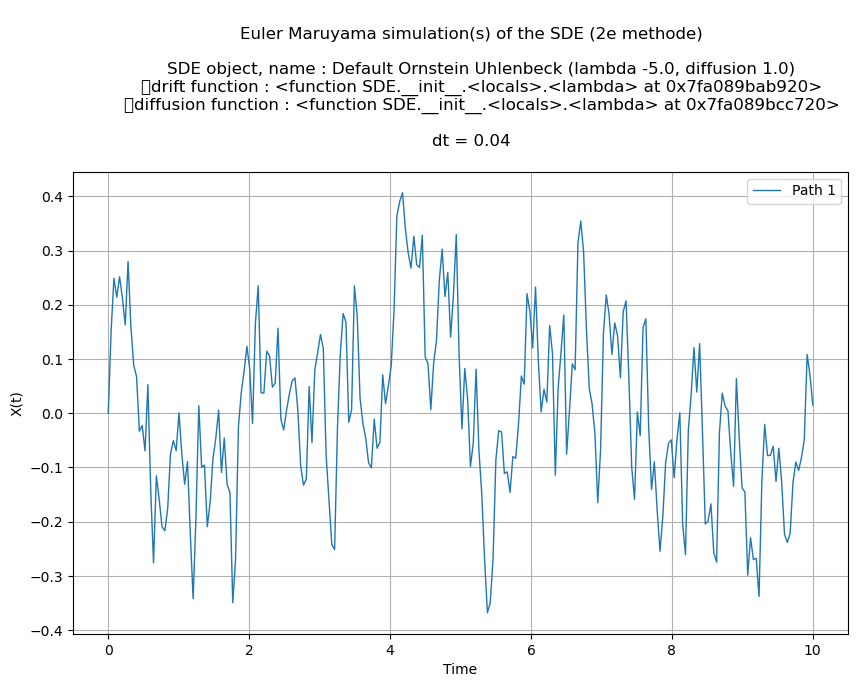

In [27]:
fig, ax = plot_sde_samples(
    ts, ys_2, 
    title=f"""
    Euler Maruyama simulation(s) of the SDE (2e methode)
    {sde}
    dt = {dt:.2f}
    """
)
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Generative model for Pyro
</div>

The key assumption we make is that the drift and diffusion functions are Bayesian neural networks.

\begin{align}
F(X_t,t) &= BNN_{\text{F}}(X_t,t) \\
L(X_t,t) &= BNN_{\text{L}}(X_t,t) \\
x_0 &\sim \mathcal{N}(0.0, 1.0)
\end{align}

and compute the likelihood (assuming here constant time intervals):

\begin{align}
X_{t_{k+1}} - X_{t_k} &\approx F(X_{t_{k}}, t_k) dt + L(X_{t_k},t_k) \mathcal{N}(0,dt) \\
X_{t_{k+1}} \vert X_{t_k} &\sim \mathcal{N}\left( X_{t_{k}} + F(X_{t_{k}}, t_k) dt \, ; \, L(X_{t_k},t_k)^2 dt \right) \\
\end{align}

Leading to:
\begin{align}
p(x_{k+1} \vert x_k) &= \frac{1}{\sqrt{2\pi \sigma_k^2}} \exp{\left( -\frac{(x_{k+1} - \mu_k)^2}{2 \sigma_k^2} \right) }
\end{align}

with:
\begin{align}
\mu_k &= X_{t_{k}} + F(X_{t_{k}}, t_k) dt \\
\sigma_k^2 &= L(X_{t_k},t_k)^2 dt \\
\end{align}

Which leads to:

\begin{align}
\log{p(x_{1:N})} &= -\frac{1}{2} \sum_{k=0}^{N-1} \log{\sigma_k^2} - \frac{1}{2} \sum_{k=0}^{N-1} \frac{(x_{k+1} - \mu_k)^2}{\sigma_k^2} + \log{p(x_0)} + \text{cte}
\end{align}

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Model
</div>

NB : we declare the `model` as a function, not a class, as we aim at doing MCMC sampling with NumPyro in the end.

In [28]:
t = ts
X = ys.squeeze()

print(f'Time stamps : {t.size()}')
print(f'Values : {X.size()}')

Time stamps : torch.Size([250])
Values : torch.Size([250])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A first toy O.U. model to check our pipeline
</div>

In [29]:
def pyro_model(t, X=None, dt=dt):
    # Pyro model to learn parameters
    # inputs:
    #   t (torch.tensor) : (N_POINTS,) : this is the tensor of time steps
    #   X (torch.tensor, optional) : (N_POINTS,) : the tensor of values at times t
    
    # number of points
    N = len(t)
    dt_ = torch.tensor(dt)
    
    # priors --- here, O.U. toy case
    # NB : we posit log_Normal distributions on the diffusion as usual
    drift = pyro.sample("drift", dist.Normal(0., 1.))  
    log_diffusion = pyro.sample("log_diffusion", dist.Normal(-2.,1.))
    
    def drift_fun(x,t):
        return -drift * x
    def diffusion_fun(x,t):
        return torch.exp(log_diffusion)
    
    # this is the prior for x_0 and also the first value for the likelihood calculation
    # x0 = pyro.sample("x0", dist.Normal(0.,1.))
    x0 = torch.tensor(0.)
    x_current = x0
    
    # likelihood
    for k in pyro.markov(range(1,N)):
        mu_k = x_current + drift_fun(x_current, t[k-1]) * dt_
        sigma_k = diffusion_fun(x_current, t[k-1]) * torch.sqrt(dt_)
        x_next = pyro.sample(
            f"x_{k}", 
            dist.Normal(mu_k, sigma_k),
            obs=X[k]
            )
        x_current = x_next

In [30]:
# NB : we will need the model in a separate namespace so we can use the GPU for multiple MCMC chains

# from pyro_models import pyro_model

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
2 : MCMC Posterior Sampling
</div>

In [31]:
# reset the Store parameters
pyro.clear_param_store()

# define the NUTS kernel - takes the generative model itself.
nuts_kernel = NUTS(
    model=pyro_model,
    jit_compile=False, # True for speed, False for debugging
)

# define a MCMC sampler with the above kernel
# does NOT use the model. This is merely the executor of the MCMCKernel
N_MCMC_SAMPLES = 100
N_BURNIN = 200
N_CHAINS = 1

MCMC_runner = MCMC(
    kernel=nuts_kernel,
    num_samples=N_MCMC_SAMPLES,
    warmup_steps=N_BURNIN,
    num_chains=N_CHAINS,
    initial_params=None
)

# run the sampler
MCMC_runner.run(t,X)

Sample: 100%|██████████| 300/300 [02:38,  1.89it/s, step size=9.37e-01, acc. prob=0.917]


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
3 : Checking results of the MCMC run
</div>

In [32]:
def display_diag_MCMC(diags):

    # Extract all 'n_eff' tensors for example : number of effective samples from the Markov chains
    n_eff_list = []
    for rv_name, rv_diagnostics in diags.items():
        
        # We only care about n_eff for the parameters we are sampling (weights, biases, sigma)
        # Exclude auxiliary or internal diagnostics if they exist.
        if 'n_eff' in rv_diagnostics and rv_name not in  ['_last_state', 'potential_energy']:
            
            # n_eff might be a tensor if the site is multidimensional (like a weight matrix)
            n_eff_tensor = rv_diagnostics['n_eff']
            
            # Flatten the tensor and add all its elements to our list
            n_eff_list.append(n_eff_tensor.flatten())

    # Concatenate all n_eff tensors into a single 1D tensor
    all_n_eff = torch.cat(n_eff_list)

    # Compute the average and minimum ESS
    average_n_eff = all_n_eff.mean().item()
    min_n_eff = all_n_eff.min().item()

    print(f"Total number of stochastic parameters analyzed: {len(all_n_eff)}")
    print(f"Overall Average Effective Sample Size (ESS): {average_n_eff:.2f}")
    print(f"Minimum Effective Sample Size (ESS): {min_n_eff:.2f}")

In [33]:
# check effective sample size, etc. by getting the dictionnary of results
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
diags = MCMC_runner.diagnostics()

print(MCMC_runner.summary())
display_diag_MCMC(diags)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          drift      2.58      0.69      2.53      1.45      3.71     48.21      1.00
  log_diffusion     -0.72      0.05     -0.72     -0.79     -0.63     75.80      0.99

Number of divergences: 0
None
Total number of stochastic parameters analyzed: 2
Overall Average Effective Sample Size (ESS): 62.00
Minimum Effective Sample Size (ESS): 48.21


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
4 : Reconstruction
</div>

In [34]:
posterior_samples = MCMC_runner.get_samples()

In [35]:
posterior_samples.keys()

dict_keys(['drift', 'log_diffusion'])

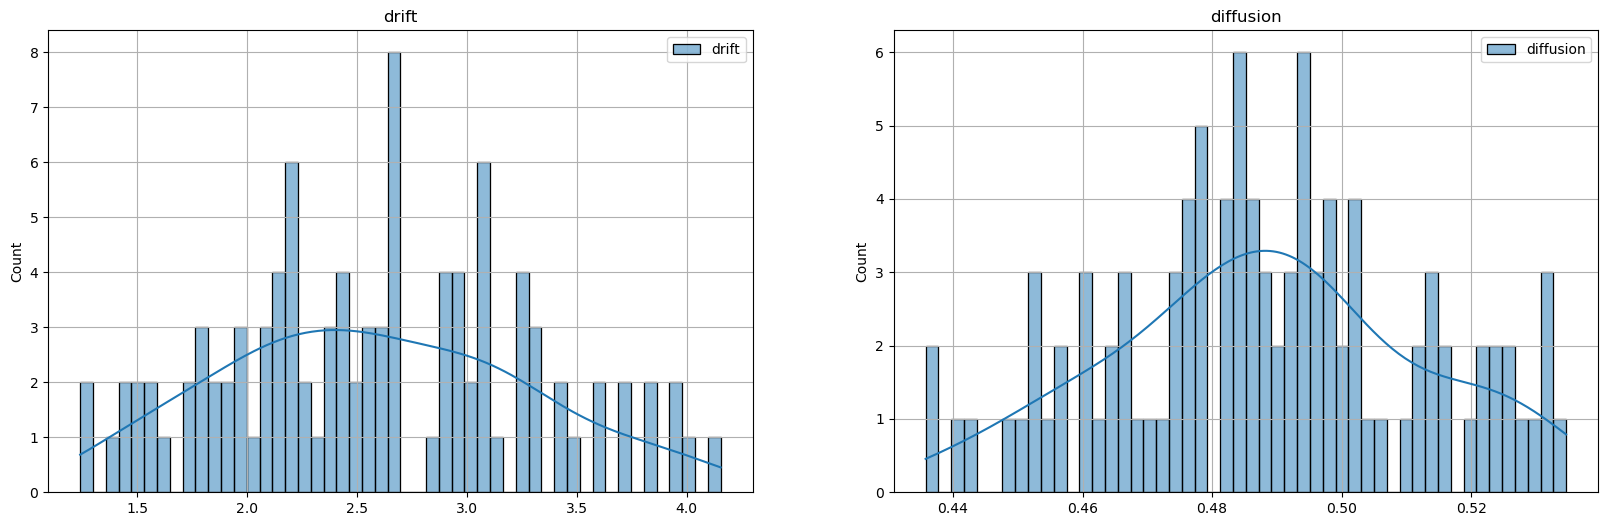

In [36]:
drift_samples = posterior_samples.get('drift')
diffusion_samples = torch.exp(posterior_samples.get('log_diffusion'))
# x0_samples = posterior_samples.get('x0')

fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=2)

sns.histplot(drift_samples.cpu().numpy(), bins=50, kde=True, label=f'drift', ax=ax[0])
ymax=ax[0].get_ylim()[1]*1.1
# ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
ax[0].set_title(f'drift')
ax[0].legend()
ax[0].grid()

sns.histplot(diffusion_samples.cpu().numpy(), bins=50, kde=True, label=f'diffusion', ax=ax[1])
ymax=ax[1].get_ylim()[1]*1.1
# ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
ax[1].set_title(f'diffusion')
ax[1].legend()
ax[1].grid()

# sns.histplot(x0_samples.cpu().numpy(), bins=50, kde=True, label=f'x0', ax=ax[2])
# ymax=ax[2].get_ylim()[1]*1.1
# # ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# # ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# # ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[2].set_title(f'x0')
# ax[2].legend()
# ax[2].grid()

In [37]:
# # get samples and analyse
# posterior_samples = MCMC_runner.get_samples()

# lambda_samples = torch.exp(posterior_samples.get("log_lambda"))
# hist_counts, bin_edges = np.histogram(lambda_samples.cpu().numpy(), bins=100)
# lambda_map = bin_edges[hist_counts.argmax()]  # approximate MAP

# sigma_samples = torch.exp(posterior_samples.get("log_sigma"))
# hist_counts, bin_edges = np.histogram(sigma_samples.cpu().numpy(), bins=100)
# sigma_map = bin_edges[hist_counts.argmax()]  # approximate MAP

# print(f'lambda :')
# print(f'\tground truth : \t{lambda_gt:.3e}')
# print(f'\tMLE : \t\t{lambda_ml:.3e}')
# print(f'\tMAP : \t\t{lambda_map:.3e}')
# print(f'sigma :')
# print(f'\tground truth : \t{sigma_gt:.3e}')
# print(f'\tMLE : \t\t{sigma_ml:.3e}')
# print(f'\tMAP : \t\t{sigma_map:.3e}')

# fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

# sns.histplot(lambda_samples.cpu().numpy(), bins=50, kde=True, label=f'lambda', ax=ax[0])
# ymax=ax[0].get_ylim()[1]*1.1
# ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[0].set_title(f'lambda')
# ax[0].legend()
# ax[0].grid()

# sns.histplot(sigma_samples.cpu().numpy(), bins=50, kde=True, label=f'sigma', ax=ax[1])
# ymax=ax[1].get_ylim()[1]*1.1
# ax[1].vlines(sigma_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
# ax[1].vlines(sigma_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
# ax[1].vlines(sigma_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
# ax[1].set_title(f'sigma')
# ax[1].legend()
# ax[1].grid()

# ax[2].scatter(lambda_samples.cpu().numpy(), sigma_samples.cpu().numpy(), marker='.', alpha=0.5)
# ax[2].scatter(lambda_gt, sigma_gt, marker='x', s=50.0, color='green', label='ground truth')
# ax[2].scatter(lambda_ml, sigma_ml, marker='x', s=50.0, color='blue', label='MLE')
# ax[2].scatter(lambda_map, sigma_map, marker='x', s=50.0, color='black', label='MAP')
# ax[2].set_title(f'lambda v sigma')
# ax[2].set_xlabel('lambda')
# ax[2].set_ylabel('sigma')
# ax[2].legend()
# ax[2].grid()

# fig.suptitle(f"MCMC sampling for O.U. with lambda x delta_t = {ldt:.3f}")

# plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Checking Posterior quality with visual reconstruction
</div>

- We sample parameters from the posterior, 
- and use the Brownian motion that was sampled to draw the data
- to try to reconstruct the data

In [38]:
N_SAMPLES = 5  # number of paths we want to reconstruct

ids = np.random.choice(int(N_MCMC_SAMPLES*N_CHAINS), N_SAMPLES)
lambdas_for_reco = lambda_samples[ids]
sigmas_for_reco = sigma_samples[ids]

print(f'lambdas sampled from posterior : {lambdas_for_reco}')
print(f'sigmas sampled from posterior : {sigmas_for_reco}')

NameError: name 'lambda_samples' is not defined

In [ ]:
ys_reco = torch.full((N_POINTS, N_SAMPLES), fill_value=y_start)

for i, (lambda_for_reco, sigma_for_reco) in enumerate(zip(lambdas_for_reco, sigmas_for_reco)):
    # looping
    print(f'path {i+1} : using lambda = {lambda_for_reco:.3e}, sigma = {sigma_for_reco:.3e}')
    # compute parameter for the EM simulation given the sampled lambda and sigma from posterior
    a = torch.exp(-lambda_for_reco*torch.tensor(dt))
    sigma_sim = sigma_for_reco * torch.sqrt(1/(2*lambda_for_reco)*(1-a**2))
    # compute path from posterior samples, with brownian motion from the data
    for j in range(1,N_POINTS):
        ys_reco[j,i] = a * ys_reco[j-1,i] + sigma_sim * bm[j-1,:]
        
ys_reco = ys_reco.unsqueeze(-1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
n_points = ts.size()[0]
n_paths = ys.size()[1]
    
for i, y in enumerate(ys_reco.permute(1,0,2)):  # iterate over paths
    l = lambdas_for_reco[i]
    s = sigmas_for_reco[i]
    ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), color='blue', lw=1, alpha=0.75, label=f'Path {i+1} - lambda = {l:.2e}, sigma = {s:.2e}' if i<10 else None)  # plot each path
       
ax.plot(ts.cpu().numpy(), ys.squeeze().cpu().numpy(), color='black', alpha=1.0, label='ground truth', marker='x')

title = f"RECONSTRUCTING DATA with sampled lambdas, sigmas \nsame brownian motion as ground truth data\nground truth : lambda = {lambda_gt:.3f}, sigma = {sigma_gt:.3f}" 
ax.set_title(title)
ax.set_xlabel("Time")
ax.set_ylabel("X(t)")
ax.legend()
ax.grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Forecasting
</div>

- We draw lambdas, sigmas from the posterior
- We draw random motions from t_end to t_forecast
- We compute paths from t_end to t_end + t_forecast

In [ ]:
N_SAMPLES = N_MCMC_SAMPLES * N_CHAINS  # number of paths we want to reconstruct

ids = np.random.choice(int(N_MCMC_SAMPLES*N_CHAINS), N_SAMPLES)
lambdas_for_reco = lambda_samples[ids]
sigmas_for_reco = sigma_samples[ids]

print(f'lambdas sampled from posterior : {lambdas_for_reco.size()}')
print(f'sigmas sampled from posterior : {sigmas_for_reco.size()}')

In [ ]:
N_NEW_POINTS = 20
t_forecast = t_end + N_NEW_POINTS * dt
ts_forecast = torch.linspace(t_end, t_forecast, N_NEW_POINTS)

# sampling Brownian motions - we will reuse them for the reconstruction
y_start_forecast = ys[-1].item()
ys_forecast = torch.full((N_NEW_POINTS, N_SAMPLES), fill_value=y_start_forecast)

# sampling Brownian motions
bm = torch.randn((N_NEW_POINTS-1, N_SAMPLES))

# computing forecasts
for i, (lambda_for_reco, sigma_for_reco) in enumerate(zip(lambdas_for_reco, sigmas_for_reco)):
    # looping
    # print(f'forecast path {i+1} : using lambda = {lambda_for_reco:.3e}, sigma = {sigma_for_reco:.3e}, and BM = {bm[:5,i]}')
    # compute parameter for the EM simulation given the sampled lambda and sigma from posterior
    a = torch.exp(-lambda_for_reco*torch.tensor(dt))
    sigma_sim = sigma_for_reco * torch.sqrt(1/(2*lambda_for_reco)*(1-a**2))
    # compute path from posterior samples, with brownian motion from the data
    for j in range(1,N_NEW_POINTS):
        ys_forecast[j,i] = a * ys_forecast[j-1,i] + sigma_sim * bm[j-1,i]

mean_forecast = torch.mean(ys_forecast, dim=1)
ys_forecast = ys_forecast.unsqueeze(-1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
# n_points = ts.size()[0]
# n_paths = ys.size()[1]
LAST_POINTS = 20
    
for i, y in enumerate(ys_forecast.permute(1,0,2)):  # iterate over paths
    l = lambdas_for_reco[i]
    s = sigmas_for_reco[i]
    ax.plot(ts_forecast.detach().cpu().numpy(), y.detach().cpu().numpy(), color='blue', lw=1, alpha=0.2) # label=f'Path {i+1} - lambda = {l:.2e}, sigma = {s:.2e}' if i<5 else None)  # plot each path

ax.plot(ts[-LAST_POINTS:].cpu().numpy(), ys[-LAST_POINTS:].squeeze().cpu().numpy(), color='black', alpha=1.0, label='ground truth', marker='x')
ax.plot(ts_forecast.detach().cpu().numpy(), mean_forecast.detach().cpu().numpy(), color='red', lw=2, linestyle='-', label='simulations mean', alpha=1.0)    

title = f"FORECASTING paths with sampled lambdas, sigmas \nsampled brownian motion in the future" 
ax.set_title(title)
ax.set_xlabel("Time")
ax.set_ylabel("X(t)")
ax.legend()
ax.grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A note on whether or not posterior sampling is useful...
</div>

Recall that 

\begin{align}
dX_t &= - \lambda X_t dt + \sigma dB_t \\
X_0 &= x_0
\end{align}

The big take-away is that if
\begin{align}
\lambda \Delta t << 1
\end{align}

Then $(X_t)_{t \geq 0}$ is close to:
\begin{align}
dX_t &\sim \sigma dB_t \\
X_0 &= x_0
\end{align}

That is the observed $X_t$ is close to a **random walk** and it is very difficult to estimate $\lambda$.

The O.U. process becomes indistinguishable from a random walk at that time scale.

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 60px; color: black; font-weight: bold;">
Take-aways
</div>

High-frequency ≠ high information for λ.

If $\lambda \Delta_t << 1$, treat the path as approximately a Wiener process; focus on $\sigma$

To infer $\lambda$ reliably, you need:
- Larger $\Delta t$, or
- Longer total observation window, spanning multiple relaxation times - ie $\lambda \Delta_t \geq 0.1$ for example